# Thick Sample Ptychography Reconstruction Tutorial 2D

This tutorial demonstrates how to use `thick_ptycho` to Reconstruction a problem with multiple probes via PWE and Multislice.


### 1. Import Libraries: Sample Space and Forward Model


In [1]:
import os
from thick_ptycho.reconstruction.ms_reconstructor import ReconstructorMS
from thick_ptycho.reconstruction.pwe_reconstructor import ReconstructorPWE

from thick_ptycho.simulation.config import SimulationConfig, ProbeConfig
from thick_ptycho.simulation.ptycho_probe import create_ptycho_probes
from thick_ptycho.simulation.scan_frame import Limits
from thick_ptycho.simulation.simulation_space import create_simulation_space

import time
import numpy as np

from scipy.ndimage import zoom

from utils import plot_data

## 2. Load Simulated Data

In [2]:
# File path
npz_file_path = os.path.join("./data", "simulated_data_petsc_fine_grid.npz")

# Load the file. MUST use allow_pickle=True since the config was pickled.
loaded_data = np.load(npz_file_path, allow_pickle=True)

# Accessing the contents:

# 1. Load the NumPy arrays directly
exit_waves = loaded_data["exit_waves"]
ref_index = loaded_data["ref_index"]

# 2. Load the sim_config.
loaded_sim_config = loaded_data["sim_config"].item()

print(f"Successfully loaded arrays and config from {npz_file_path}.")

Successfully loaded arrays and config from ./data/simulated_data_petsc_fine_grid.npz.


In [3]:
# Reduce Stepsize px
step_size_px = 10
points_per_wavelength = 4

print(f"Reduce Stepsize px: {loaded_sim_config['step_size_px']} -> {step_size_px}")
print(
    f"Points per wavelength: {loaded_sim_config['points_per_wavelength']} -> {points_per_wavelength}"
)
spatial_limits = Limits(
    x=loaded_sim_config["spatial_limits"]["x"],  # Sample width
    z=loaded_sim_config["spatial_limits"]["z"],  # Sample thickness
    units=loaded_sim_config["spatial_limits"]["units"],
)
probe_config = ProbeConfig(
    type=loaded_sim_config["probe_config"]["type"],
    wave_length=loaded_sim_config["probe_config"][
        "wave_length"
    ],  # meters (0.635 μm). Visible light
    diameter=loaded_sim_config["probe_config"]["diameter"],  # [m]
    focus=loaded_sim_config["probe_config"]["focus"],  # focal length [m]
)
sim_config = SimulationConfig(
    probe_config=probe_config,
    # Spatial discretization
    scan_points=loaded_sim_config["scan_points"],
    step_size_px=step_size_px,
    pad_factor=loaded_sim_config["pad_factor"],
    solve_reduced_domain=loaded_sim_config["solve_reduced_domain"],
    points_per_wavelength=points_per_wavelength,
    spatial_limits=spatial_limits,
    # Refractive index or Transmission Function Constant Surrounding Medium
    medium=loaded_sim_config["medium"],  # 1.0 for free space
    # Logging and results
    results_dir=loaded_sim_config["results_dir"],
    use_logging=loaded_sim_config["use_logging"],
)
simulation_space = create_simulation_space(sim_config)
simulation_space.summarize()

ptycho_probes = create_ptycho_probes(simulation_space)

2025-12-14 16:01:00,177 - INFO - === Scan Summary ===
2025-12-14 16:01:00,178 - INFO -   Sample space (x-range): 1.500e-04 m
2025-12-14 16:01:00,178 - INFO -   Sample space (z-range): 4.000e-05 m
2025-12-14 16:01:00,179 - INFO -   Sample Pixels:          1501 px
2025-12-14 16:01:00,180 - INFO -   Step size:              10 px
2025-12-14 16:01:00,181 - INFO -   Number of scan points:  60
2025-12-14 16:01:00,181 - INFO -   Steps in z:             251
2025-12-14 16:01:00,182 - INFO -   Solve reduced domain:   910 px
2025-12-14 16:01:00,182 - INFO -   Max Overlap Pixels:     901 px
2025-12-14 16:01:00,183 - INFO -   Probe diameter:         1.000e-05 m
2025-12-14 16:01:00,183 - INFO -   Probe Pixels:           100 px
2025-12-14 16:01:00,184 - INFO -   Max Overlap:            9.000e-06 m
2025-12-14 16:01:00,185 - INFO -   Percentage Overlap:     90.00%



Reduce Stepsize px: 40 -> 10
Points per wavelength: 32 -> 4


## 3. Reduce Data Dimensionality

Original exit waves shape: (60, 3640)
Coarse exit waves shape: (60, 910)


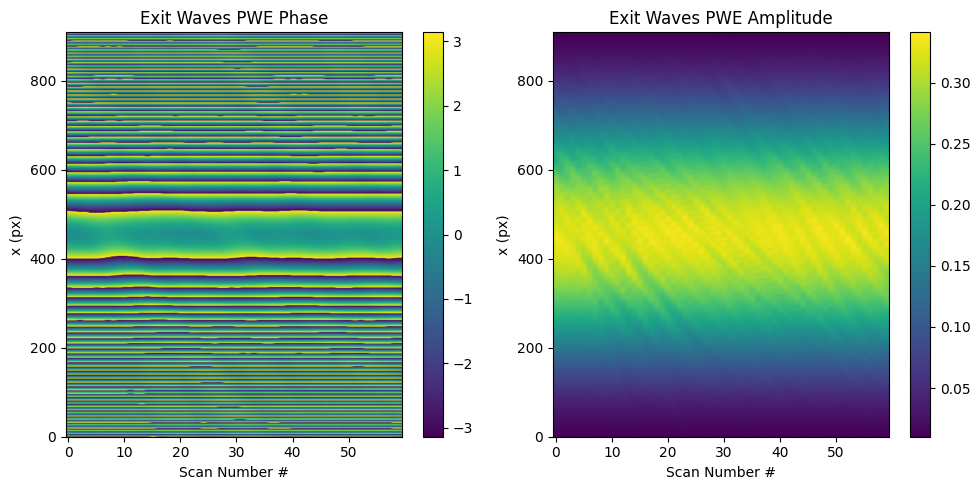

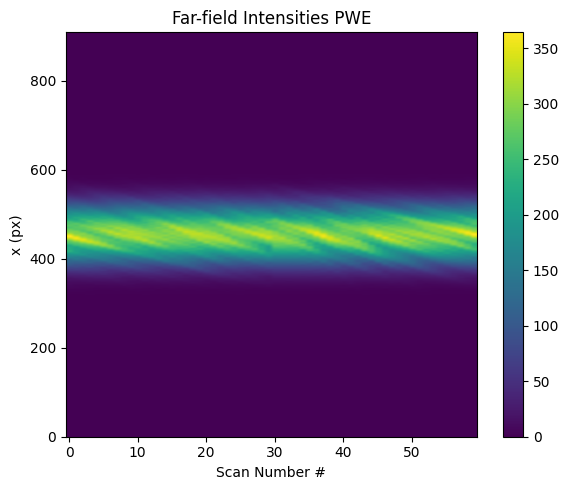

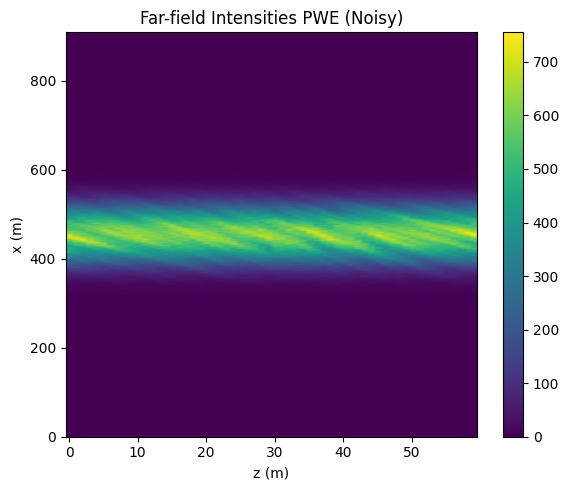

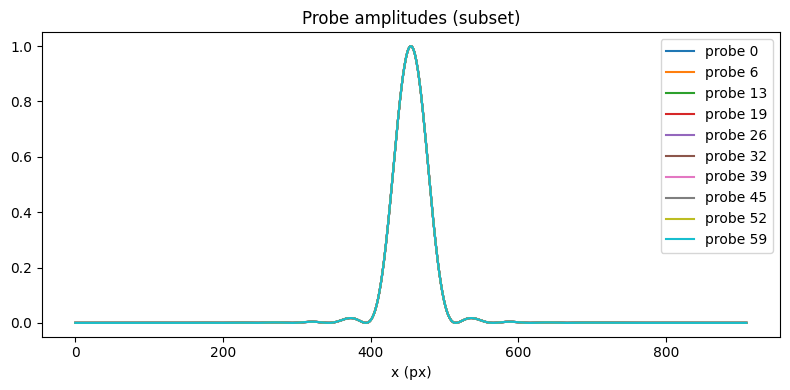

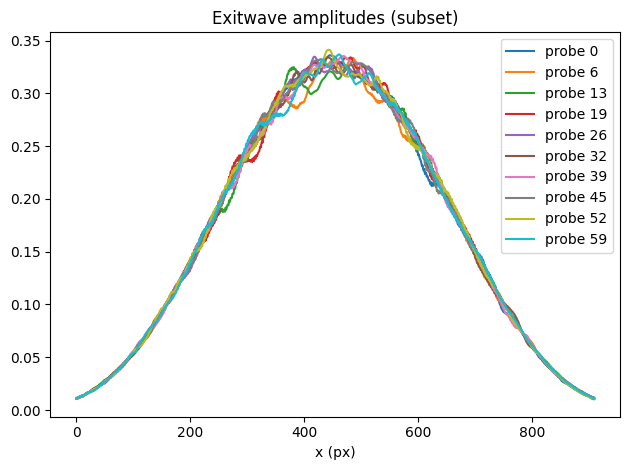

In [4]:
original_shape = exit_waves.shape
target_shape = (original_shape[0], simulation_space.effective_nx)
zoom_factors = np.array(target_shape) / np.array(original_shape)

data_ew = zoom(exit_waves, zoom_factors, order=1)
data = np.abs(np.fft.fft(data_ew)) ** 2

print(f"Original exit waves shape: {exit_waves.shape}")
print(f"Coarse exit waves shape: {data_ew.shape}")

plot_data(
    data=data,
    exitwaves=data_ew,
    simulation_space=simulation_space,
    probes=ptycho_probes,
)

### 4. Reconstructs on Coarser nz Discretization
The exit wave of the forward solution can be set as the initial condition for
the system to be solved in reverse. 

2025-12-14 16:01:01,101 - INFO - Initialized Multislice 3PIE Reconstructor.


2025-12-14 16:01:02,600 - INFO - [Iter 001] Mean Loss = 0.160405, Time = 1.49 seconds
2025-12-14 16:01:04,181 - INFO - [Iter 002] Mean Loss = 0.150867, Time = 1.58 seconds
2025-12-14 16:01:05,625 - INFO - [Iter 003] Mean Loss = 0.147512, Time = 1.44 seconds
2025-12-14 16:01:07,038 - INFO - [Iter 004] Mean Loss = 0.145730, Time = 1.41 seconds
2025-12-14 16:01:08,570 - INFO - [Iter 005] Mean Loss = 0.144610, Time = 1.53 seconds
2025-12-14 16:01:09,869 - INFO - [Iter 006] Mean Loss = 0.143835, Time = 1.30 seconds
2025-12-14 16:01:11,347 - INFO - [Iter 007] Mean Loss = 0.143266, Time = 1.48 seconds
2025-12-14 16:01:12,823 - INFO - [Iter 008] Mean Loss = 0.142829, Time = 1.47 seconds
2025-12-14 16:01:14,214 - INFO - [Iter 009] Mean Loss = 0.142482, Time = 1.39 seconds
2025-12-14 16:01:15,620 - INFO - [Iter 010] Mean Loss = 0.142201, Time = 1.41 seconds
2025-12-14 16:01:17,057 - INFO - [Iter 011] Mean Loss = 0.141967, Time = 1.44 seconds
2025-12-14 16:01:19,108 - INFO - [Iter 012] Mean Loss 

Reconstruction time: 46.38 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for MS Reconstruction'}, xlabel='Iteration', ylabel='RMSE'>)

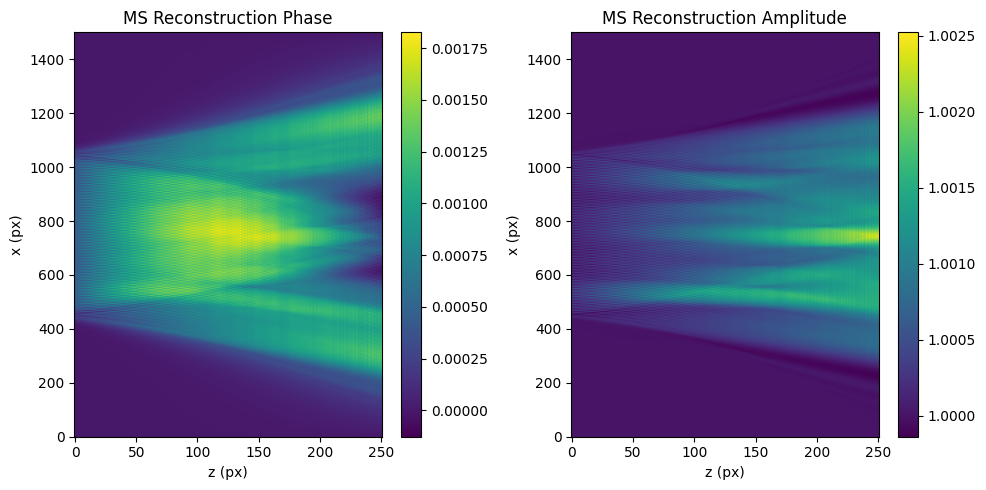

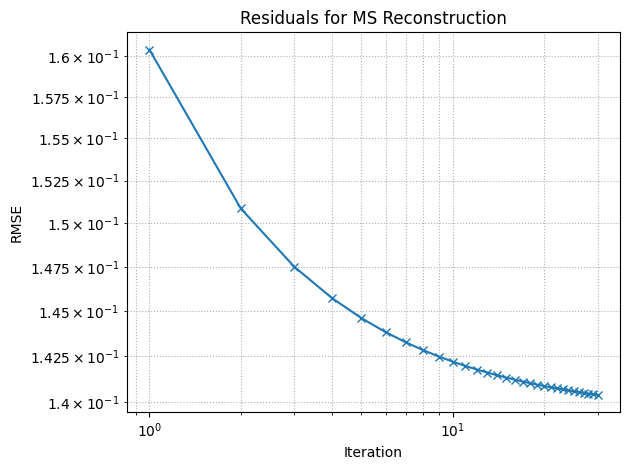

In [5]:
recon_ms = ReconstructorMS(
    simulation_space, data_ew, phase_retrieval=False, verbose=True
)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=30, alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space.viewer.plot_two_panels(
    n_est_ms,
    view="phase_amp",
    title="MS Reconstruction",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_ms,
    title="Residuals for MS Reconstruction",
)

/home/dnz75396/thick_ptycho/thick_ptycho/forward_model/pwe/solvers/utils/_pint_utils.py:171: SparseEfficiencyWarning: splu converted its input to CSC format
  spla.splu((self.A_bar - (z * self.B_bar)).astype(self.dtype))
/home/dnz75396/thick_ptycho/thick_ptycho/forward_model/pwe/solvers/utils/_pint_utils.py:184: SparseEfficiencyWarning: splu converted its input to CSC format
  spla.splu((A_bar_H - (z_conj * B_bar_H)).astype(self.dtype))
2025-12-14 16:01:48,608 - INFO - Initializing Least Squares Solver...
2025-12-14 16:01:48,652 - INFO - Iteration 1/30
2025-12-14 16:01:52,888 - INFO -     RMSE: 0.10556006523355947
2025-12-14 16:02:12,923 - INFO -     Iteration 1 took 24.27 seconds.
2025-12-14 16:02:12,926 - INFO - Iteration 2/30
2025-12-14 16:02:28,146 - INFO -     RMSE: 0.09995897653222661
2025-12-14 16:03:16,559 - INFO -     Iteration 2 took 63.63 seconds.
2025-12-14 16:03:16,561 - INFO - Iteration 3/30
2025-12-14 16:03:28,068 - INFO -     RMSE: 0.09913474789492747
2025-12-14 16:04:1

Reconstruction time: 2083.91 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for PWE Reconstruction'}, xlabel='Iteration', ylabel='RMSE'>)

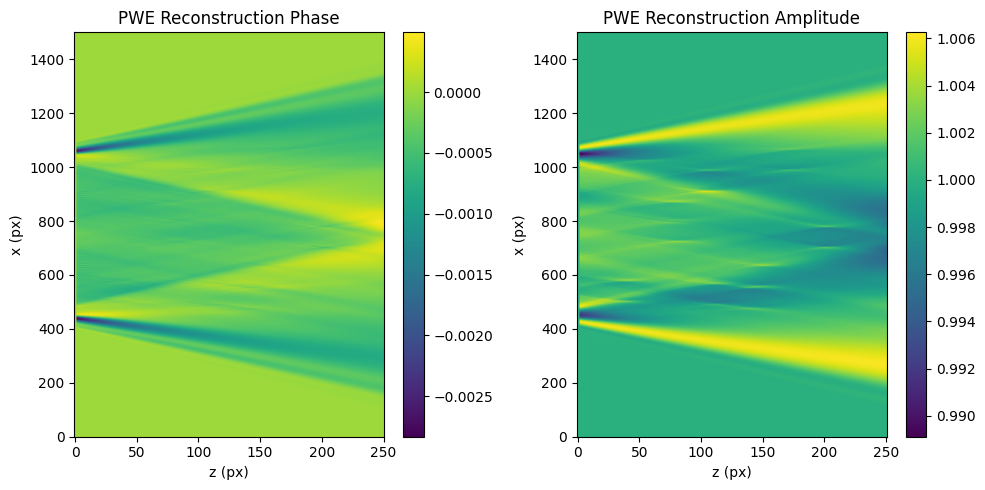

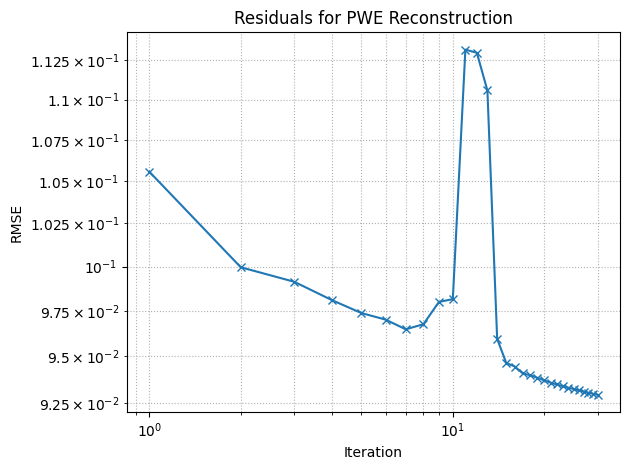

In [6]:
atol = 1e-4
alpha = 1e-8
recon_pwe = ReconstructorPWE(
    simulation_space, data_ew, phase_retrieval=False, verbose=True, 
    solver_type="full",
    alpha=alpha,
    atol=atol,
)
time_start = time.time()
n_est_pwe, u, residual_pwe = recon_pwe.reconstruct(max_iters=30)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")

simulation_space.viewer.plot_two_panels(
    n_est_pwe,
    view="phase_amp",
    title="PWE Reconstruction",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_pwe,
    title="Residuals for PWE Reconstruction",
)

## Phase Retrieval

2025-12-14 16:36:33,363 - INFO - Initialized Multislice 3PIE Reconstructor.
2025-12-14 16:36:34,879 - INFO - [Iter 001] Mean Loss = 0.007846, Time = 1.51 seconds
2025-12-14 16:36:36,414 - INFO - [Iter 002] Mean Loss = 0.007063, Time = 1.53 seconds
2025-12-14 16:36:40,780 - INFO - [Iter 003] Mean Loss = 0.006759, Time = 4.36 seconds
2025-12-14 16:36:42,316 - INFO - [Iter 004] Mean Loss = 0.006602, Time = 1.53 seconds
2025-12-14 16:36:44,426 - INFO - [Iter 005] Mean Loss = 0.006510, Time = 2.11 seconds
2025-12-14 16:36:45,964 - INFO - [Iter 006] Mean Loss = 0.006453, Time = 1.54 seconds
2025-12-14 16:36:47,466 - INFO - [Iter 007] Mean Loss = 0.006416, Time = 1.50 seconds
2025-12-14 16:36:48,957 - INFO - [Iter 008] Mean Loss = 0.006393, Time = 1.49 seconds
2025-12-14 16:36:50,449 - INFO - [Iter 009] Mean Loss = 0.006378, Time = 1.49 seconds
2025-12-14 16:36:51,945 - INFO - [Iter 010] Mean Loss = 0.006369, Time = 1.49 seconds
2025-12-14 16:36:53,563 - INFO - [Iter 011] Mean Loss = 0.006364

Reconstruction time: 51.73 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for MS Reconstruction with Phase Retrieval'}, xlabel='Iteration', ylabel='RMSE'>)

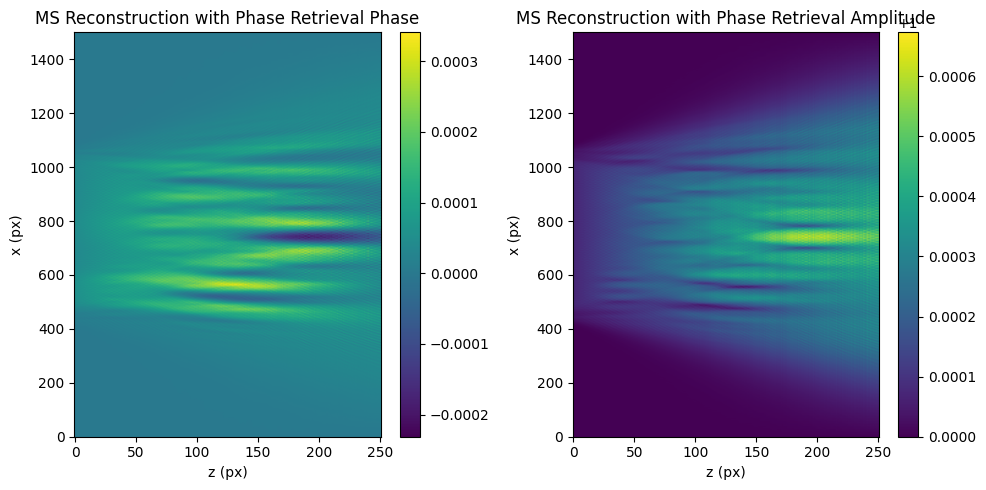

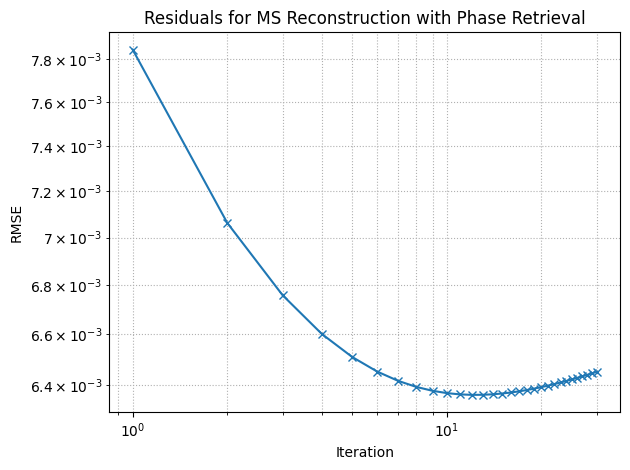

In [7]:
recon_ms = ReconstructorMS(simulation_space, data, phase_retrieval=True, verbose=True)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=30, alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_ms,
    view="phase_amp",
    title="MS Reconstruction with Phase Retrieval",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_ms,
    title="Residuals for MS Reconstruction with Phase Retrieval",
)

2025-12-14 16:37:26,006 - INFO - Initializing Least Squares Solver...
2025-12-14 16:37:26,031 - INFO - Iteration 1/30
2025-12-14 16:37:28,967 - INFO -     RMSE: 0.00838109970952155
2025-12-14 16:37:37,613 - INFO -     Iteration 1 took 11.58 seconds.
2025-12-14 16:37:37,614 - INFO - Iteration 2/30
2025-12-14 16:37:43,621 - INFO -     RMSE: 0.006743574314967861
2025-12-14 16:38:18,422 - INFO -     Iteration 2 took 40.81 seconds.
2025-12-14 16:38:18,426 - INFO - Iteration 3/30
2025-12-14 16:38:31,243 - INFO -     RMSE: 0.006432189030962506
2025-12-14 16:39:07,670 - INFO -     Iteration 3 took 49.24 seconds.
2025-12-14 16:39:07,672 - INFO - Iteration 4/30
2025-12-14 16:39:15,219 - INFO -     RMSE: 0.006213632899893791
2025-12-14 16:39:57,591 - INFO -     Iteration 4 took 49.92 seconds.
2025-12-14 16:39:57,592 - INFO - Iteration 5/30
2025-12-14 16:40:06,612 - INFO -     RMSE: 0.00600259196400888
2025-12-14 16:40:48,848 - INFO -     Iteration 5 took 51.26 seconds.
2025-12-14 16:40:48,857 - I

Reconstruction time: 1358.24 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for PWE Reconstruction with Phase Retrieval'}, xlabel='Iteration', ylabel='RMSE'>)

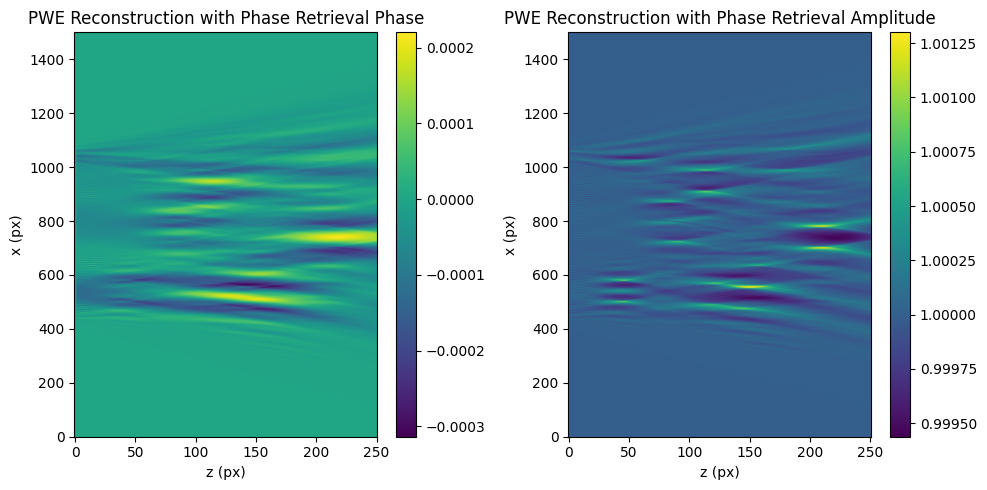

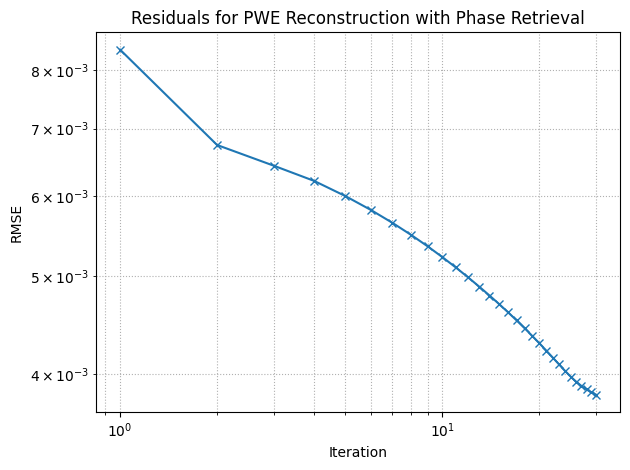

In [8]:
recon_pwe = ReconstructorPWE(simulation_space, data, phase_retrieval=True, verbose=True,
                             solver_type="full",
    alpha=alpha,
    atol=atol)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=30)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_pwe,
    view="phase_amp",
    title="PWE Reconstruction with Phase Retrieval",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_pwe,
    title="Residuals for PWE Reconstruction with Phase Retrieval",
)

# Phase Retrieval (noisy data)

In [9]:
rng = np.random.default_rng(seed=42)
data_noisy = data.copy() + rng.poisson(np.abs(data))

2025-12-14 17:00:08,234 - INFO - Initialized Multislice 3PIE Reconstructor.


2025-12-14 17:00:09,995 - INFO - [Iter 001] Mean Loss = 0.067792, Time = 1.76 seconds
2025-12-14 17:00:11,571 - INFO - [Iter 002] Mean Loss = 0.044248, Time = 1.57 seconds
2025-12-14 17:00:13,475 - INFO - [Iter 003] Mean Loss = 0.032979, Time = 1.90 seconds
2025-12-14 17:00:15,314 - INFO - [Iter 004] Mean Loss = 0.027442, Time = 1.84 seconds
2025-12-14 17:00:17,151 - INFO - [Iter 005] Mean Loss = 0.025474, Time = 1.84 seconds
2025-12-14 17:00:18,622 - INFO - [Iter 006] Mean Loss = 0.025694, Time = 1.47 seconds
2025-12-14 17:00:20,235 - INFO - [Iter 007] Mean Loss = 0.027090, Time = 1.61 seconds
2025-12-14 17:00:21,846 - INFO - [Iter 008] Mean Loss = 0.029028, Time = 1.61 seconds
2025-12-14 17:00:23,349 - INFO - [Iter 009] Mean Loss = 0.031164, Time = 1.50 seconds
2025-12-14 17:00:24,768 - INFO - [Iter 010] Mean Loss = 0.033324, Time = 1.42 seconds
2025-12-14 17:00:26,181 - INFO - [Iter 011] Mean Loss = 0.035425, Time = 1.41 seconds
2025-12-14 17:00:27,733 - INFO - [Iter 012] Mean Loss 

Reconstruction time: 51.51 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for MS Reconstruction with Phase Retrieval (Noisy Data)'}, xlabel='Iteration', ylabel='RMSE'>)

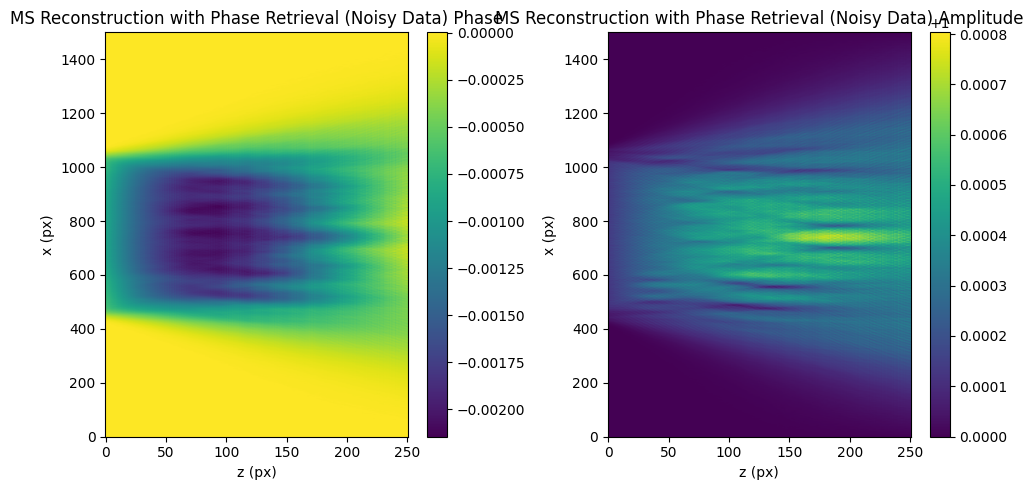

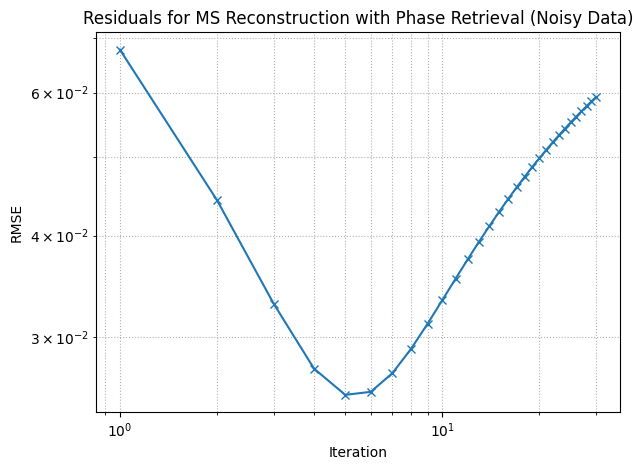

In [10]:
recon_ms = ReconstructorMS(
    simulation_space, data_noisy, phase_retrieval=True, verbose=True
)
time_start = time.time()
n_est_ms, residual_ms = recon_ms.reconstruct(max_iters=30, alpha_obj=1e-4)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_ms,
    view="phase_amp",
    title="MS Reconstruction with Phase Retrieval (Noisy Data)",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_ms,
    title="Residuals for MS Reconstruction with Phase Retrieval (Noisy Data)",
)

2025-12-14 17:01:00,774 - INFO - Initializing Least Squares Solver...
2025-12-14 17:01:00,795 - INFO - Iteration 1/30
2025-12-14 17:01:07,625 - INFO -     RMSE: 0.0812204580075757
2025-12-14 17:01:24,165 - INFO -     Iteration 1 took 23.37 seconds.
2025-12-14 17:01:24,166 - INFO - Iteration 2/30
2025-12-14 17:01:34,094 - INFO -     RMSE: 0.05542919527517101
2025-12-14 17:02:08,737 - INFO -     Iteration 2 took 44.57 seconds.
2025-12-14 17:02:08,739 - INFO - Iteration 3/30
2025-12-14 17:02:16,768 - INFO -     RMSE: 0.04018331856873802
2025-12-14 17:02:59,656 - INFO -     Iteration 3 took 50.92 seconds.
2025-12-14 17:02:59,659 - INFO - Iteration 4/30
2025-12-14 17:03:12,427 - INFO -     RMSE: 0.03277455305308054
2025-12-14 17:03:48,194 - INFO -     Iteration 4 took 48.53 seconds.
2025-12-14 17:03:48,196 - INFO - Iteration 5/30
2025-12-14 17:03:56,853 - INFO -     RMSE: 0.029011680988445573
2025-12-14 17:04:30,417 - INFO -     Iteration 5 took 42.22 seconds.
2025-12-14 17:04:30,419 - INFO

Reconstruction time: 1490.62 seconds


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Residuals for PWE Reconstruction with Phase Retrieval (Noisy Data)'}, xlabel='Iteration', ylabel='RMSE'>)

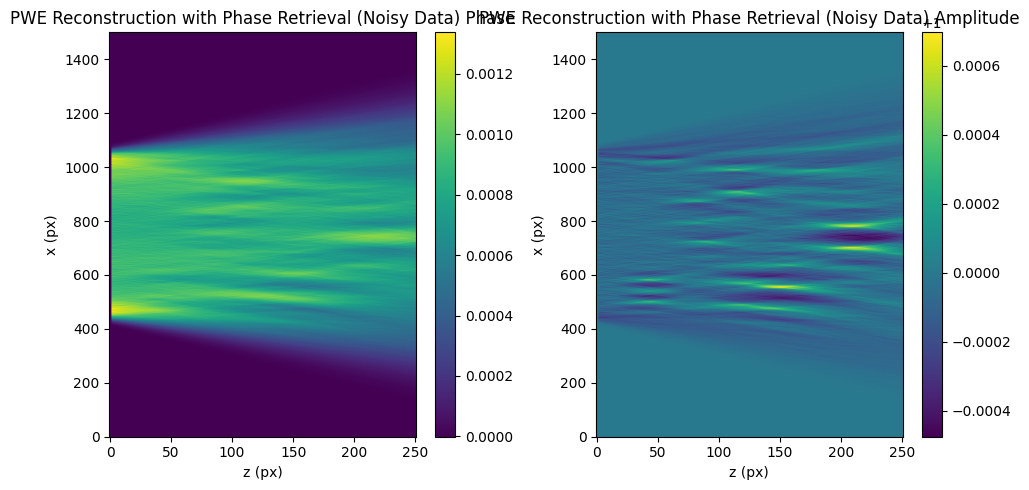

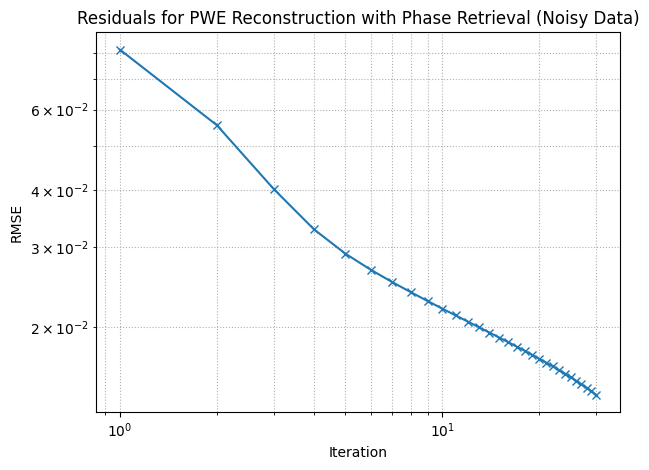

In [11]:
recon_pwe = ReconstructorPWE(
    simulation_space, data_noisy, phase_retrieval=True, verbose=True,
    solver_type="full",
    alpha=alpha,
    atol=atol,
)
time_start = time.time()
n_est_pwe, recon_u_pwe, residual_pwe = recon_pwe.reconstruct(max_iters=30)
time_end = time.time()
print(f"Reconstruction time: {time_end - time_start:.2f} seconds")
simulation_space.viewer.plot_two_panels(
    n_est_pwe,
    view="phase_amp",
    title="PWE Reconstruction with Phase Retrieval (Noisy Data)",
    xlabel="z (px)",
    ylabel="x (px)",
)
simulation_space.viewer.plot_residual(
    residual_pwe,
    title="Residuals for PWE Reconstruction with Phase Retrieval (Noisy Data)",
)